In [4]:
import numpy as np
import cv2
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from utils.dataset import ImageSet, transform
from utils.metrics import plot_metrics

# OpenCV inpainting

In [5]:
def classic_inpaint(img, mask, radius=3):
    return cv2.inpaint(img, mask, inpaintRadius=radius, flags=cv2.INPAINT_TELEA)

# Neural Network inpainting

### Dataset

In [6]:
train_dataset = ImageSet("data/inpainting/train", "data/intermediate/train", transform, impainting=True)
valid_dataset = ImageSet("data/inpainting/valid", "data/intermediate/valid", transform, impainting=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Model

In [7]:
class InpaintingCNN(nn.Module):
    def __init__(self):
        super(InpaintingCNN, self).__init__()

        # **Encoder** (Ekstrakcja cech)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 256 -> 128
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 32 -> 16
            nn.ReLU()
        )

        # **Decoder** (Rekonstrukcja obrazu)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 128 -> 256
            nn.Sigmoid()  # Sigmoid, bo chcemy wartości w zakresie 0-1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# model = InpaintingCNN()
# model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

In [10]:
# import tqdm

# num_epochs = 10
# losses = {"train":[],"val":[]}


# for epoch in range(num_epochs):
#     model.train()
#     for x, y in tqdm.tqdm(train_dataloader):
#         optimizer.zero_grad()
#         x, y = x.to(device), y.to(device)

#         out = model(x)
        
#         loss = criterion(out, y)

#         loss.backward()
#         optimizer.step()
    
#     model.eval()
#     print(f"epoch #{epoch+1}, loss: {loss}")
#     losses["train"].append(loss)
#     with torch.no_grad():
#         total_loss = 0.0
#         for x, y in valid_dataset:
#             x, y = x.to(device), y.to(device)

#             out = model(x)

#             loss = criterion(out, y)


#             total_loss += loss.item()
#         print("Validation loss:",total_loss)
#     losses["val"].append(total_loss)

In [11]:
# x = range(num_epochs)
# y = losses['val']

# plt.plot(x, y)
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("loss on valid")
# plt.show()

In [12]:
# torch.save(model, "model_inpainting.pth")

### Results

In [13]:
model = torch.load("model_inpainting.pth", weights_only=False)
model.to(device)

InpaintingCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

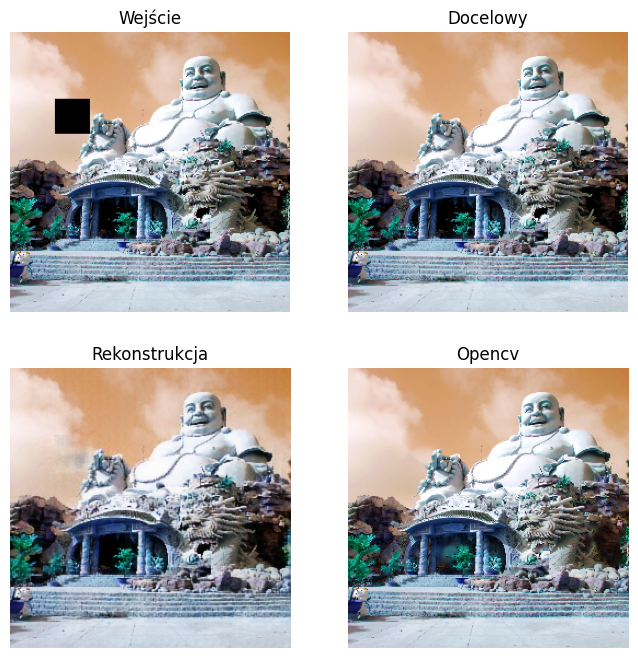

In [14]:
a = random.choice(valid_dataset)
# a = valid_dataset[25]
model.eval()

out = model(a[0].to(device))
out = out.permute(1, 2, 0).detach().cpu().numpy()
# out = denormalize(out)  # na liczbach z przedziału (0, 1) też jakoś wyświetla więc nie trzeba denormalize

dest = a[1].permute(1, 2, 0).detach().numpy()
input = a[0].permute(1, 2, 0).detach().numpy()


black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255
image_uint8 = (input * 255).astype(np.uint8)
out1 = cv2.inpaint(image_uint8, black_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
# dest = denormalize(dest)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0, 0].imshow(input)
axes[0, 0].axis('off')
axes[0, 0].set_title("Wejście")

axes[0, 1].imshow(dest)
axes[0, 1].axis('off')
axes[0, 1].set_title("Docelowy")

axes[1, 0].imshow(out)
axes[1, 0].axis('off')
axes[1, 0].set_title("Rekonstrukcja")

axes[1, 1].imshow(out1)
axes[1, 1].axis('off')
axes[1, 1].set_title("Opencv")

plt.show()

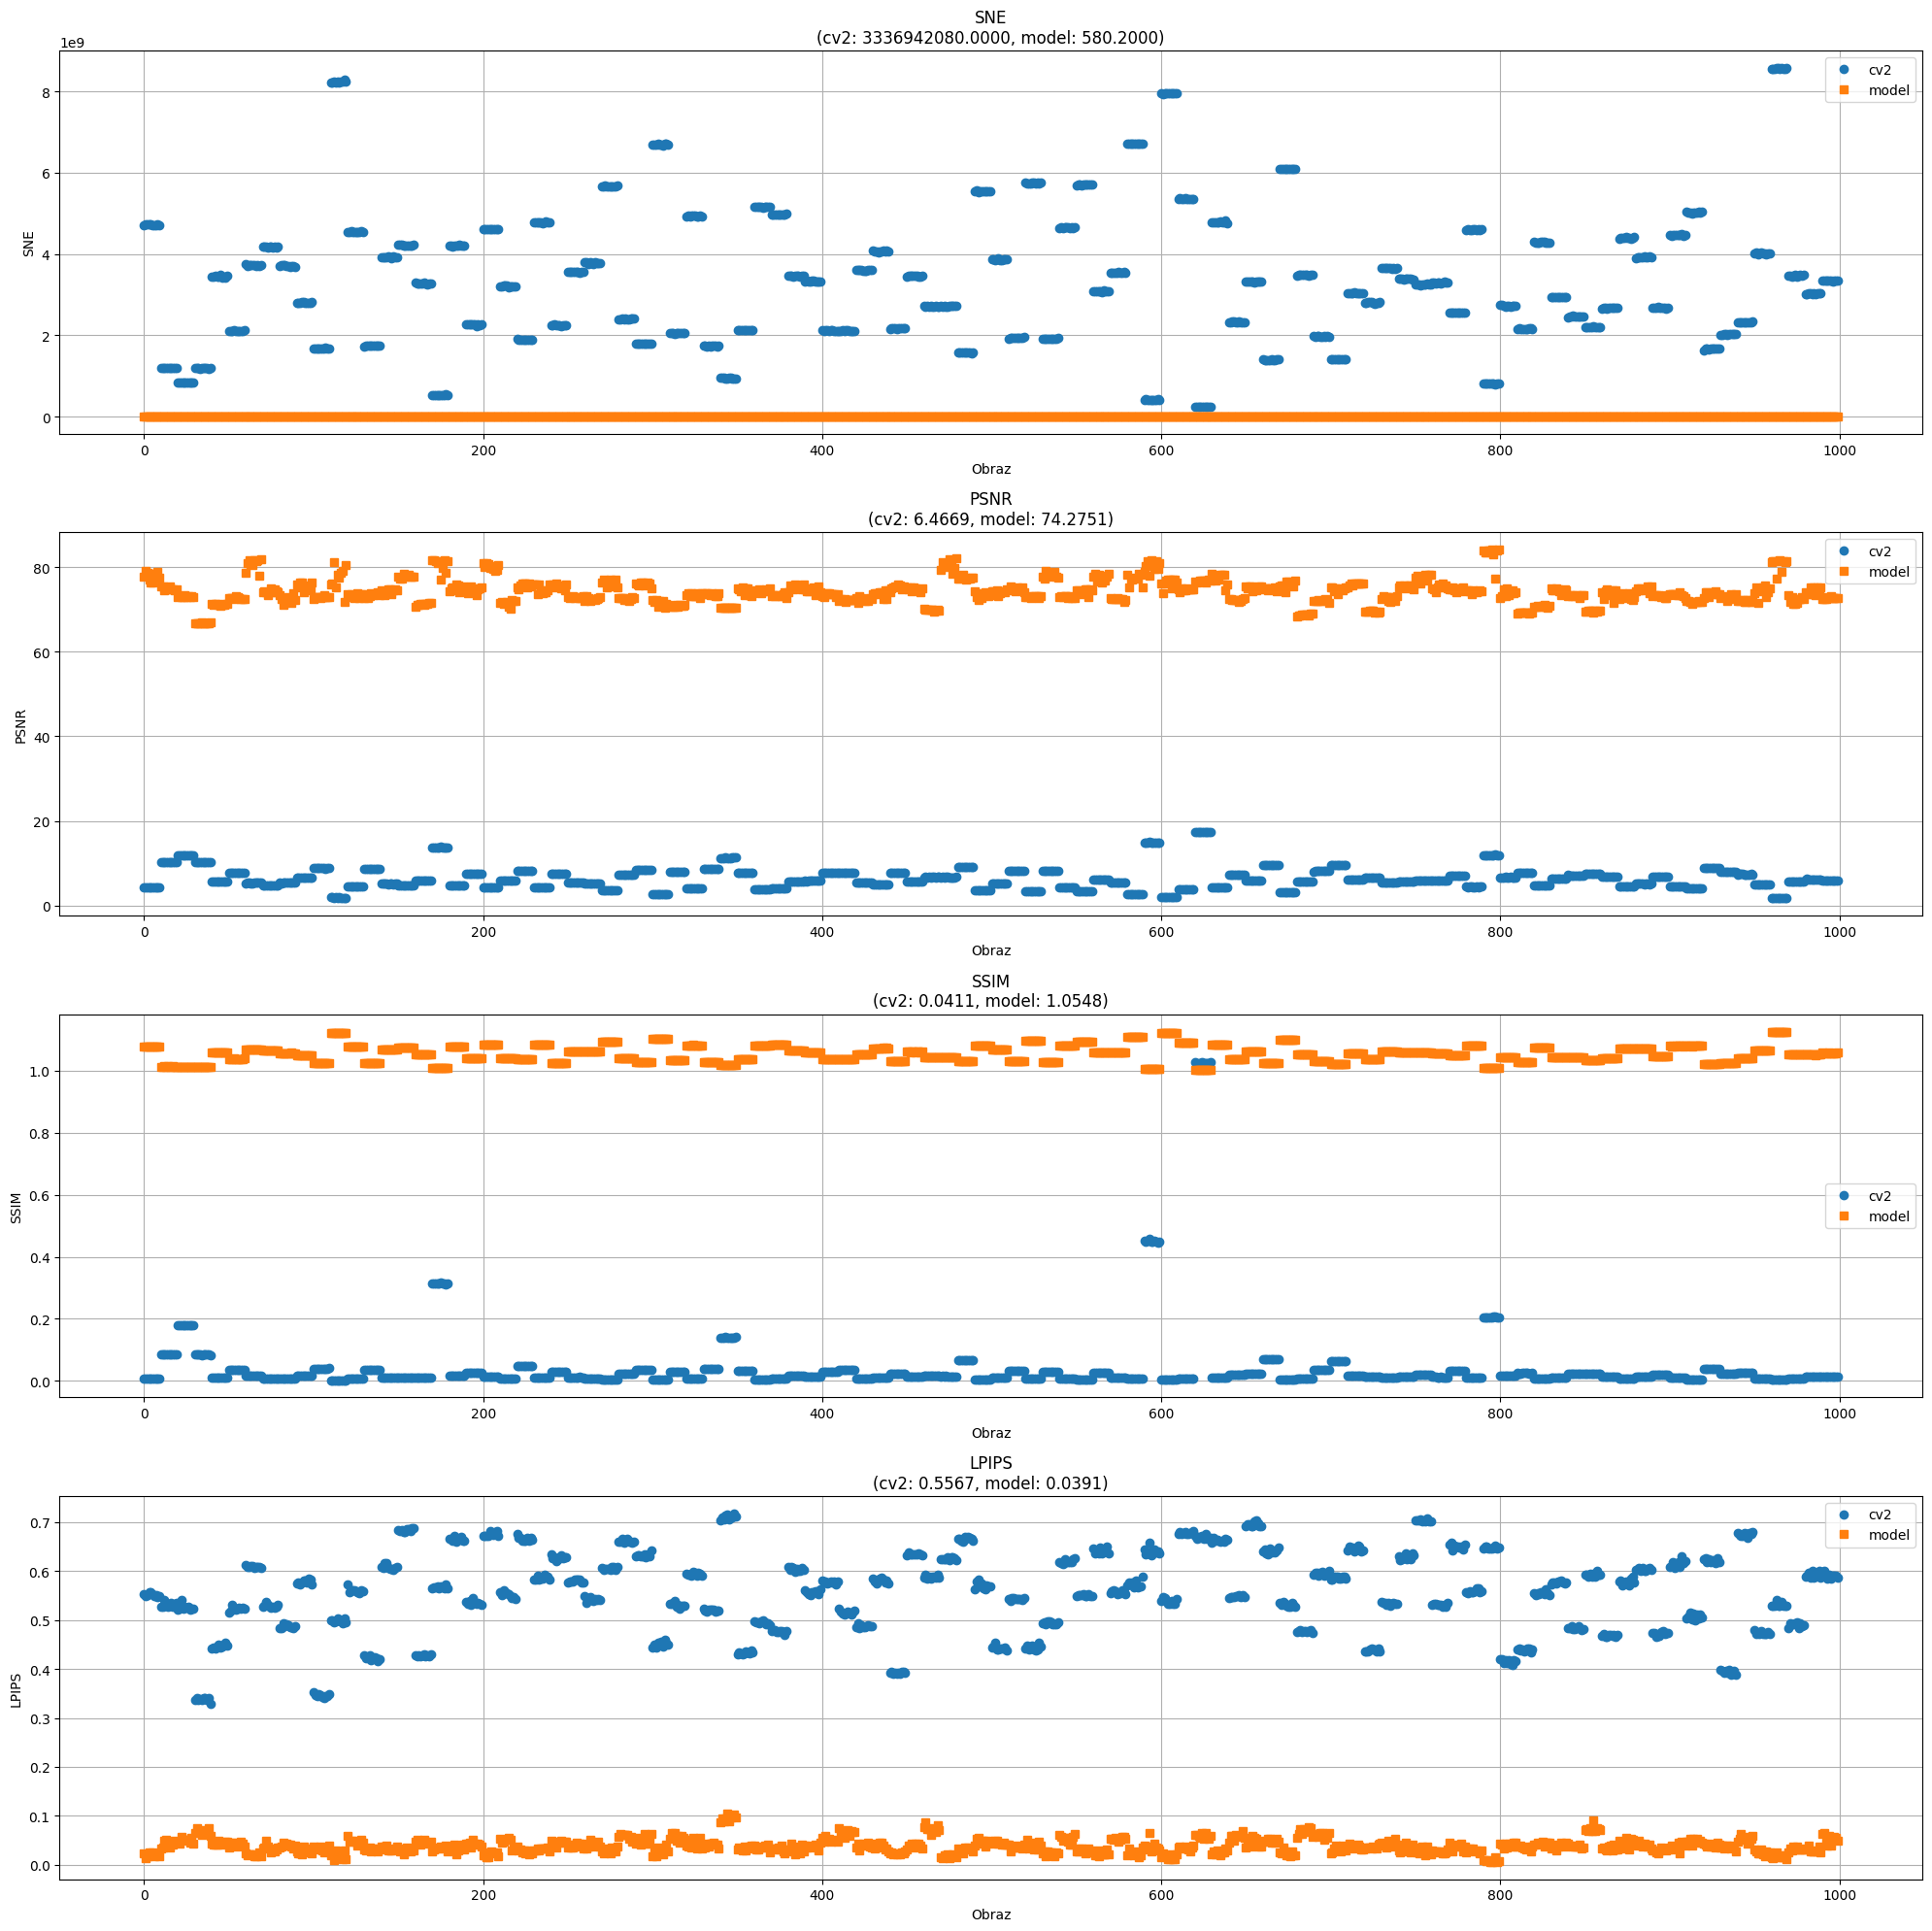

In [15]:
ground_truth_list = []
cv2_list = []
model_list = []

model.eval()

for x, y in valid_dataset:
    ground_truth_list.append(y.permute(1, 2, 0).detach().numpy())

    input = x.permute(1, 2, 0).detach().numpy()

    black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255

    cv2_list.append(classic_inpaint((input * 255).astype(np.uint8), black_mask))

    model_list.append(model(x.to(device)).permute(1, 2, 0).detach().cpu().numpy())

plot_metrics(ground_truth_list, cv2_list, model_list)